#** Classification Analysis of Lead Qualification Dataset**

The data associated with this notebok can de downloaded [here](https://drive.google.com/file/d/1AK2zWojZWFa1xZqLOQ3VRdzjX0kEDo5H/view?usp=sharing)

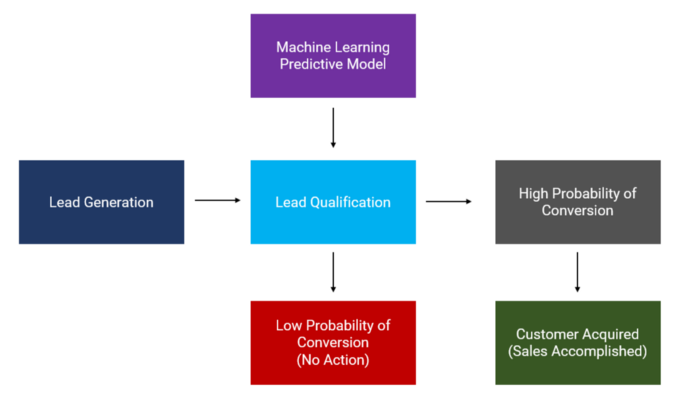

Source: https://towardsdatascience.com/predict-lead-score-the-right-way-using-pycaret-332faa780cfc Fair use claimed.

#**Table of Contents**
* Metrics
* Executive SUmmary (BLUF)
* Conclusions from Data Preprocessing
* Libraries
* Data
* Resolve Missing Values
* Encodings
* Outliers
* Set Up Predictors & Target
* Recursive Feature Elimination (RFE)
* Classifier Horse Race
* Winner Winner Chicken Dinner
* Use Tuned XGBoost Model to Generate Propensities
* Conclusion



##Metrics##
The score sought by X Education will be the propensity of conversion of an instance, as modeled by a classifier. The primary for development of the classifiert will be AUC, as it measures separation of the categories (i.e., *decisiveness*)  by a classifier. Once a classifier has been selected, the number of leads that should be cherry-picked to ensure that around 80% of the selected leads convert will be determined after rank-ordering the propensities.

#**Executive Summary (BLUF)**
An XGBoost model with an AUC of 0.879 for AUC and accuracy of 0.887 is proposed for scoring leads based upon propensity. It is expected that 80% of the instances in the top ~34.5% of leads from the wild, ordered by propensity (as scored by the XGBoost model), will ultimately convert.
The model should be retrained and the lead cherry-picking percentage analysis revisited as the quality of the stream of incoming leads may vary over time.

#**Conclusions from Data Preprocessing**

*   No duplicates.
*   Resolved missing values by deleting features with a high number of NaNs, features with an highly dominant value, and by using median imputation for features with a small number of missing values.
*   Resolved missing values in the 'City' feature by treating NaN's there as a special category.
*   Consilidated infrequent values in remaining features into an "Other" category.
*   One-hot encoded categorical features.
*   Trimmed outliers (5%, 95%), and this resolved skewness concerns also.
*   Principal components analysis does not appear useful as the first component explains 30% of the variance, but then a multitude of components explain 1-10% of the variance.
*   The following features were identified as important using RFE: ['Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_Lead Add Form', 'Tags_Closed by Horizzon',
       'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Lead Quality_Might be',
       'Lead Quality_Not Sure', 'Last Notable Activity_SMS Sent']

#**Libraries**

In [ ]:
# Basic Libraries
import pandas as pd
import seaborn as sns

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math

In [ ]:
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV


In [ ]:
# XGBoost
from xgboost import XGBClassifier

In [ ]:
# LightGBM
#!pip install lightgbm
from lightgbm import LGBMClassifier

In [ ]:
# imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [ ]:
# scikitplot
!pip install scikit-plot
import scikitplot as skplt

#**Data**

In [ ]:
# Read Data
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Read
file_ = "drive/My Drive/Colab Notebooks/Big Data ML/New BDML/Data/Marketing_Leads_India.csv"   # adapt this as needed to the file structure on your Google drive
df = pd.read_csv(file_) # read in csv file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure maximum display for pandas
pd.set_option('display.max_columns', None)

# Shape of df
print("Shape", df.shape)

# Check data types
print(df.info())

# Head  tail of df
print(df.head())
print(df.tail())

Shape (9240, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Number                                    9240 non-null   int64  
 1   Lead Origin                                    9240 non-null   object 
 2   Lead Source                                    9204 non-null   object 
 3   Do Not Email                                   9240 non-null   object 
 4   Do Not Call                                    9240 non-null   object 
 5   Converted                                      9240 non-null   int64  
 6   TotalVisits                                    9103 non-null   float64
 7   Total Time Spent on Website                    9240 non-null   int64  
 8   Page Views Per Visit                           9103 non-null   float64
 9   Last Activity                      

#**Resolve Missing Values**

In [ ]:
# Delete 'Lead Number' as it is an index
if 'Lead Number' in df.columns:
  df = df.drop(['Lead Number'],axis=1)

In [ ]:
# Correct NaN's in features with a small number of missing values
# Fixing NaNs in 'Lead Source'
print(df['Lead Source'].describe())
df['Lead Source'] = df['Lead Source'].replace(np.nan, 'Google')

# Fixing NaNs in 'TotalVisits'
print('\n\n',df['TotalVisits'].describe())
df['TotalVisits'] = df['TotalVisits'].replace(np.nan, 3)

# Fixing NaNs in 'Page Views Per Visit'
print('\n\n',df['Page Views Per Visit'].describe())
df['Page Views Per Visit'] = df['Page Views Per Visit'].replace(np.nan, 2)

# Fixing NaNs in 'Last Activity'
print('\n\n',df['Last Activity'].describe())
df['Last Activity'] = df['Last Activity'].replace(np.nan, 'Email Opened')

# Check for missing values
print('\n\nMissing Values\n',df.isnull().sum(axis=0))

count       9204
unique        21
top       Google
freq        2868
Name: Lead Source, dtype: object


 count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64


 count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64


 count             9137
unique              17
top       Email Opened
freq              3437
Name: Last Activity, dtype: object


Missing Values
 Lead Origin                                         0
Lead Source                                         0
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                         0
Total Ti

In [ ]:
# Treat NaNs in 'City' with "No City" label
df = df.replace(np.NaN, "No City")

In [ ]:
# Delete features wih more than 50% NaNs: 'How did you hear about X Education', 'Lead Profile', 'Asymmetrique Activity Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Index', and 'Asymmetrique Profile Score' as there are too many missing values in those features
if 'How did you hear about X Education' in df.columns:
  df = df.drop(['How did you hear about X Education'],axis=1)
if 'Lead Profile' in df.columns:
  df = df.drop(['Lead Profile'],axis=1)
if 'Asymmetrique Activity Index' in df.columns:
  df = df.drop(['Asymmetrique Activity Index'],axis=1)
if 'Asymmetrique Activity Score' in df.columns:
  df = df.drop(['Asymmetrique Activity Score'],axis=1)
if 'Asymmetrique Profile Index' in df.columns:
  df = df.drop(['Asymmetrique Profile Index'],axis=1)
if 'Asymmetrique Profile Score' in df.columns:
  df = df.drop(['Asymmetrique Profile Score'],axis=1)

In [ ]:
# Consolidate rare values in selected features into "Other" category

# Lead Origin
df['Lead Origin'] = df['Lead Origin'].replace(['Quick Add Form'], 'Lead Add Form')

# Column: Lead Source
df['Lead Source'] = df['Lead Source'].replace(['google'], 'Google')
df['Lead Source'] = df['Lead Source'].replace(['bing', 'Click2call', 'Live Chat', 'NC_EDM', 'Pay per Click Ads', 'Press_Release',
  'Social Media', 'WeLearn', 'blog', 'youtubechannel','testone', 'welearnblog_Home','Other'], 'Other')

# Column: What is your current occupation
df['What is your current occupation'] = df['What is your current occupation'].replace(['Housewife','Businessman','Other'], 'Other')

# Column: Last Activity
df['Last Activity'] = df['Last Activity'].replace(['Unreachable','Unsubscribed','Had a Phone Conversation',
                                                   'View in browser link Clicked','Visited Booth in Tradeshow', 'Approached upfront',
                                                   'Resubscribed to emails','Email Received', 'Email Marked Spam','Other'], 'Other')

#Column: Last Notable Activity
df['Last Notable Activity'] = df['Last Notable Activity'].replace(['Unsubscribed','Unreachable', 'Email Bounced', 'Unsubscribed' 'Unreachable', 'Had a Phone Conversation', 'Email Marked Spam',
                                  'Email Received', 'Form Submitted on Website', 'View in browser link Clicked',
                                  'Resubscribed to emails', 'Approached upfront','Other'], 'Other')

# Column: Tags
df['Tags'] = df['Tags'].replace(['invalid number', 'wrong number given', 'In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized','Other'], 'Other')



In [ ]:
# Delete columns that have one extremely dominant value
if 'Get updates on DM Content ' in df.columns:
  df = df.drop(['Get updates on DM Content'],axis=1)
if 'I agree to pay the amount through cheque' in df.columns:
  df = df.drop(['I agree to pay the amount through cheque'],axis=1)
if 'Update me on Supply Chain Content' in df.columns:
  df = df.drop(['Update me on Supply Chain Content'],axis=1)
if 'Receive More Updates About Our Courses' in df.columns:
  df = df.drop(['Receive More Updates About Our Courses'],axis=1)
if 'Do Not Call' in df.columns:
  df = df.drop(['Do Not Call'],axis=1)
if 'Newspaper' in df.columns:
  df = df.drop(['Newspaper'],axis=1)
if 'Get updates on DM Content' in df.columns:
  df = df.drop(['Get updates on DM Content'],axis=1)
if 'Newspaper Article' in df.columns:
  df = df.drop(['Newspaper Article'],axis=1)
if 'Magazine' in df.columns:
  df = df.drop(['Magazine'],axis=1)
if 'Receive More Updates About Our Courses' in df.columns:
  df = df.drop(['Receive More Updates About Our Courses'],axis=1)
if 'What matters most to you in choosing a course' in df.columns:
  df = df.drop(['What matters most to you in choosing a course'],axis=1)
if 'X Education Forum' in df.columns:
  df = df.drop(['X Education Forum'],axis=1)
if 'Search' in df.columns:
  df = df.drop(['Search'],axis=1)
if 'Through Recommendations' in df.columns:
  df = df.drop(['Through Recommendations'],axis=1)
if 'Digital Advertisement' in df.columns:
  df = df.drop(['Digital Advertisement'],axis=1)
if 'X Education Forums' in df.columns:
  df = df.drop(['X Education Forums'],axis=1)
if 'Country' in df.columns:
  df = df.drop(['Country'],axis=1)

#**Encodings**

In [ ]:
# One-Hot Encode Categorical Variables (except 'City')
df = pd.get_dummies(data=df, columns=['Lead Origin', 'Lead Source', 'Do Not Email',
       'Last Activity', 'Specialization', 'What is your current occupation',
       'Tags', 'Lead Quality', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],drop_first=True)


#**Outliers**

In [ ]:
# Address outliers in quant varianbles
for i in ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']:
  quantiles = df[i].quantile([0.05,0.95]).values
  print(i,quantiles,'\n\n')
  df[i][df[i] <= quantiles[0]] = quantiles[0]
  df[i][df[i] >= quantiles[1]] = quantiles[1]

TotalVisits [ 0. 10.] 


Total Time Spent on Website [   0. 1562.] 


Page Views Per Visit [0. 6.] 




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#**Set Up Predictors & Target**

In [ ]:
# Split features into X1 (quant features), X2 (qual features) and y (target)
# Identify predictors & target
X = df.drop(['Converted'], axis=1)
y = df['Converted']

#**Recursive Feature Elimination (RFE)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=54321, stratify=y)

In [ ]:
# SMOTE (oversampling)
# Data is unbalanced (38.54% converted instances)

import imblearn
print("imblearn version: ", imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12346)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

print("Shape before SMOTE: ", X_train.shape, y_train.shape, "\n")
print("Shape after SMOTE: ", X_train_SMOTE.shape, y_train_SMOTE.shape, "\n")

imblearn version:  0.8.1
Shape before SMOTE:  (6930, 71) (6930,) 

Shape after SMOTE:  (8518, 71) (8518,) 



In [ ]:
# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
X_test_std = stdsc.transform(X_test)

In [ ]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=2)    #Selecting the top n features, from about 70, to improve model robustness.
_ = rfe.fit(X_train_SMOTE_std,y_train_SMOTE)
print('Important Features\n',X.columns[rfe.support_])
rf = RandomForestClassifier()
_ = rf.fit(rfe.transform(X_train_SMOTE_std), y_train_SMOTE)
print("\n Accuracy: ",rf.score(rfe.transform(X_test_std), y_test))

Important Features
 Index(['Total Time Spent on Website', 'Lead Quality_Not Sure'], dtype='object')

 Accuracy:  0.7363636363636363


<BarContainer object of 71 artists>

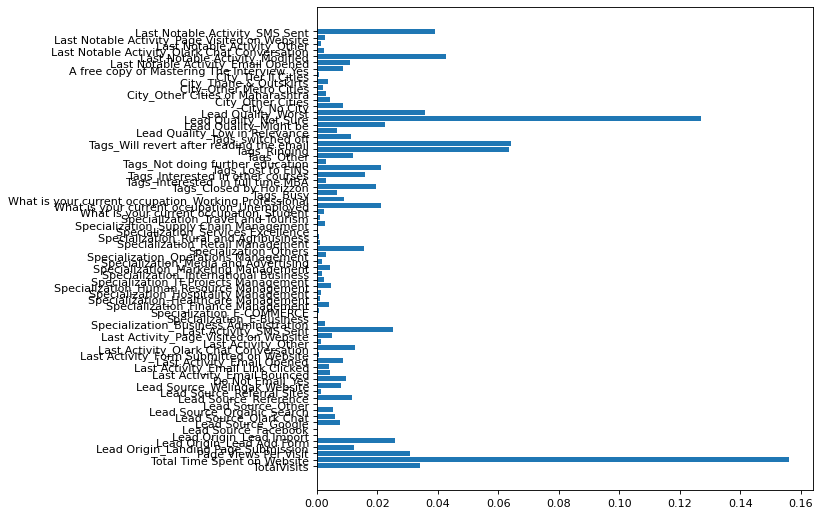

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
rf = RandomForestClassifier()
from matplotlib.pyplot import figure
col_names = X_train_SMOTE.columns
rf.fit(X_train_SMOTE_std, y_train_SMOTE)
figure(figsize=(8, 8), dpi=80)
plt.barh(col_names, rf.feature_importances_)

#**Classifier Horse Race**

In [ ]:
# Work with the set of predictors identified by RFE
best_predictors = rfe.support_              # identifies features used
new_features = []                           # X with selected features
for feature, predictor in list(zip(X, best_predictors)):
    if predictor == True:
        new_features.append(feature)

X = df[new_features]
X.shape

(9240, 2)

In [ ]:
# Workflow standardizes, SMOTEs training set, fits a classifier, and reports metrics.
# SMOTE evidently doesn't have a 'fit_transform' method, so there's no way to incorporate it into an sklearn pipeline
# We'll consider an alternative - an imblearn pipeline in the gridsearch section

names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]
classifiers = [
    Perceptron(random_state=1),
    LogisticRegression(),
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data
no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_balanced_accuracy = 0.0
  mean_auc = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
    X_test_std = stdsc.transform(X_test)
    clf.fit(X_train_SMOTE_std, y_train_SMOTE)
    y_pred = clf.predict(X_test_std)
    print(f'For fold {fold}:')
    print(f'Accuracy: {clf.score(X_test_std, y_test)}')
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}')
    print(f'AUC: {roc_auc_score(y_test, y_pred)}')
    mean_accuracy = mean_accuracy + clf.score(X_test_std, y_test)
    mean_balanced_accuracy = mean_balanced_accuracy + balanced_accuracy_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
  mean_accuracy = mean_accuracy / no_folds
  mean_balanced_accuracy = mean_balanced_accuracy / no_folds
  mean_auc = mean_auc / no_folds
  print('Average accuracy: %.3f Average balanced accuracy: %.3f Average AUC: %.3f\n\n' % (mean_accuracy, mean_balanced_accuracy, mean_auc))

CLASSIFIER:  Perceptron 

For fold 1:
Accuracy: 0.75
Balanced Accuracy: 0.7282451732869124
AUC: 0.7282451732869124
For fold 2:
Accuracy: 0.7326839826839827
Balanced Accuracy: 0.7545250435195443
AUC: 0.7545250435195443
For fold 3:
Accuracy: 0.6715367965367965
Balanced Accuracy: 0.6680942395948726
AUC: 0.6680942395948726
For fold 4:
Accuracy: 0.7429653679653679
Balanced Accuracy: 0.7636740386137046
AUC: 0.7636740386137046
For fold 5:
Accuracy: 0.7229437229437229
Balanced Accuracy: 0.6670270804628948
AUC: 0.6670270804628949
Average accuracy: 0.724 Average balanced accuracy: 0.716 Average AUC: 0.716


CLASSIFIER:  Logistic Regression 

For fold 1:
Accuracy: 0.7472943722943723
Balanced Accuracy: 0.7422950625098907
AUC: 0.7422950625098907
For fold 2:
Accuracy: 0.7364718614718615
Balanced Accuracy: 0.7379480534894762
AUC: 0.7379480534894761
For fold 3:
Accuracy: 0.7218614718614719
Balanced Accuracy: 0.7252779316347524
AUC: 0.7252779316347523
For fold 4:
Accuracy: 0.7510822510822511
Balanced A

#**Winner Winner Chicken Dinner**
We'll pick XGBoost as the winning algorithm and tune the hyperparameters using gridsearch

In [ ]:
# Create an XGBoost pipeline with SMOTE and StandardScaler and then gridsearch it using five cross-validation folds
# Execution takes ~13 minutes using Colab Pro. Reduce the number of parameters and levels of each parameter to speed up execution
model = imbpipeline([
        ('sample', SMOTE()),
        ('std', StandardScaler()),
        ('clf', XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False))])

param_grid = {
    'clf__max_depth': range (2, 10, 1),
    'clf__n_estimators': range(60, 220, 40),
    'clf__gamma': [1,5,10],
    'clf__learning_rate': [0.1, 0.05, 0.01, 0.005]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring = 'roc_auc')
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_estimator_)

{'clf__gamma': 10, 'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 180}
Pipeline(steps=[('sample', SMOTE()), ('std', StandardScaler()),
                ('clf',
                 XGBClassifier(eval_metric='auc', gamma=10,
                               grow_policy='lossguide', max_depth=2,
                               n_estimators=180, tree_method='hist',
                               use_label_encoder=False))])


#**Use Tuned XGBoost Model to Generate Propensities**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=54321, stratify=y)

In [ ]:
# SMOTE (oversampling)
# Data is unbalanced (38.54% converted instances)

import imblearn
print("imblearn version: ", imblearn.__version__)

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12346)
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)

print("Shape before SMOTE: ", X_train.shape, y_train.shape, "\n")
print("Shape after SMOTE: ", X_train_SMOTE.shape, y_train_SMOTE.shape, "\n")

imblearn version:  0.8.1
Shape before SMOTE:  (6930, 2) (6930,) 

Shape after SMOTE:  (8518, 2) (8518,) 



In [ ]:
# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)
X_test_std = stdsc.transform(X_test)

In [ ]:
#Fit best XGBoost model, predict test data
clf = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          gamma=5,
                          learning_rate=0.05,
                          max_depth=5)
clf.fit(X_train_SMOTE_std,y_train_SMOTE)
y_pred = clf.predict(X_test_std)
print(f'AUC: {roc_auc_score(y_test, y_pred)}')
print(f'Accuracy: {clf.score(X_test_std, y_test)}')

AUC: 0.7564844120905206
Accuracy: 0.7588744588744589


In [ ]:
# Reporting
print(confusion_matrix(y_test, y_pred))
print("Accuracy = ",accuracy_score(y_test, y_pred))
print("Recall = ",recall_score(y_test, y_pred))

[[1089  331]
 [ 226  664]]
Accuracy =  0.7588744588744589
Recall =  0.7460674157303371


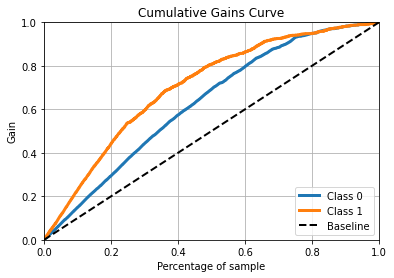

Analysis: 80% of first 483  instances rank-ordered by propensity are positive actuals in test dataset of size  2310
Percentage of rank-ordered data to take as leads:  20.90909090909091
LEADS:



,Actual,Predicted,Propensity
0,1,1,0.908625
1,1,1,0.908625
2,1,1,0.908625
3,1,1,0.908625
4,1,1,0.908625
...,...,...,...
479,1,1,0.809172
480,1,1,0.809172
481,1,1,0.809172
482,1,1,0.809172


In [ ]:
# Rank order propsensities & display the first n records of the test dataset for which 80% are actual positives.
# Report the value of n as a percentage of the size of the test dataset

# First, compute the propensitiies of iunstances in the test dataset
clf_propensities = pd.DataFrame(clf.predict_proba(X_test_std))

# Create a dataframe showing actuals, predicted, and propensities
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, clf_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

# Sort the instances in results by propsensity
results.sort_values(by=['Propensity'], inplace=True, ascending=False)
results.reset_index(drop = True , inplace = True)

# Plot gains chart
skplt.metrics.plot_cumulative_gain(y_test, clf_propensities)
plt.show()

# Find the top-rated instances in results such that the actual positive label for 'Converted' of those instances is greater than or equal to 80%
# We will assume the first lead has a positive actual
index = 2
n = 1
fraction = 1
while ((index < len(results)) & (fraction >= 0.8)):
  if results.loc[index,'Actual'] == 1:
    n=n+1
  fraction = n/index
  index = index + 1

print('Analysis: 80% of first',n,' instances rank-ordered by propensity are positive actuals in test dataset of size ',len(results))
print('Percentage of rank-ordered data to take as leads: ',100*n/len(results))
print('LEADS:\n')
results.loc[:n]

#**Conclusions**
An horse race was staged featuring the Perceptron, Logistic Regression, "SVM (RBF kernel), Decision Tree, Naive Bayes, k Nearest Neighbors, Multilayer Perceptron, Random Forest, XG Boost, and LightGBM classifiers. XGBoost was selected as the winner based upon the AUC metric and then tuned. The tuned XGBoost model produces scores of 0.888 for AUC and of 0.893 for the accuracy metric.

The model was developed using 10 predictors identified by Recursive Feature Elimination. SMOTE and standardization transformations were applied to the data.

Propsensities generated by the XGBoost model were sorted by propensity, and the top-rated records found such that 80% of them are actual conversions (i.e., 'Converted' = 1). It is expected that 80% of the instances in the top ~34.5% of leads from the wild, ordered by propensity, will ultimately convert. The gains chart analysis supports this cherry-picking percentage of the leads.